**Women's Clothing E-Commerce Reviews**

**EDA(non text)**

1.1 Load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('data/WomensClothingE-CommerceReviews.csv')

1.2 Basic info

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


1.3 Missing Value and dupliacte

C:\Users\Alvis\AppData\Local\Temp\ipykernel_27408\332695394.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')


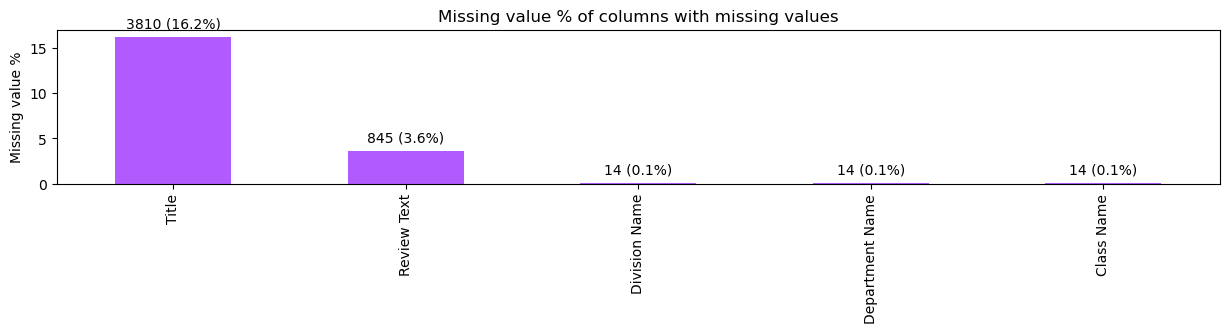

In [7]:
# missing value % and counts
col_with_missing = [c for c in df.columns if df[c].isnull().sum() >= 1]
missing_counts = df[col_with_missing].isnull().sum().sort_values(ascending=False)
total_rows = len(df)
missing_percentages = (missing_counts / total_rows) * 100

#plot
plt.figure(figsize=(15, 2))
ax = missing_percentages.plot.bar(color='#B15BFF')

for i, (col, count) in enumerate(zip(missing_counts.index, missing_counts)):
    ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')

plt.ylabel("Missing value %")
plt.title("Missing value % of columns with missing values")
plt.show()

In [8]:
# Delete rows with missing values in "Review Text"
print("Rows before deleting missing values in review text: ", df.shape[0])
df.dropna(subset=['Review Text'], inplace=True)
print("Rows after deleting missing values in review text: ", df.shape[0])

Rows before deleting missing values in review text:  23486
Rows after deleting missing values in review text:  22641


In [9]:
# Fill in missing values with blank for other object type columns
col_with_missing.remove('Review Text')
for c in col_with_missing:
    if c=='Title':
           df[c] =df[c].fillna(' ')
    else:
           df[c]=df[c].fillna('Blank')
                    
df.isna().sum().sum()

0

In [10]:
# Drop "Unamed: 0" column
df.drop("Unnamed: 0", axis=1, inplace=True)

In [11]:
# check duplicates
print(f"Rows with duplicates: {df.duplicated().sum()}")

Rows with duplicates: 1


In [12]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(f"Rows in df after dropping duplicates: {df.shape[0]}")

Rows in df after dropping duplicates: 22640


1.4 Distribution

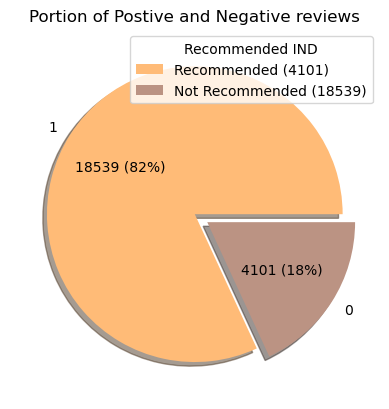

In [15]:
# Plot dependent variable distribution
# parameters for plot
sizes = df['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#FFBB77', '#bb9383']  

# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended ({sizes[0]})", f"Not Recommended ({sizes[1]})"])
plt.show()

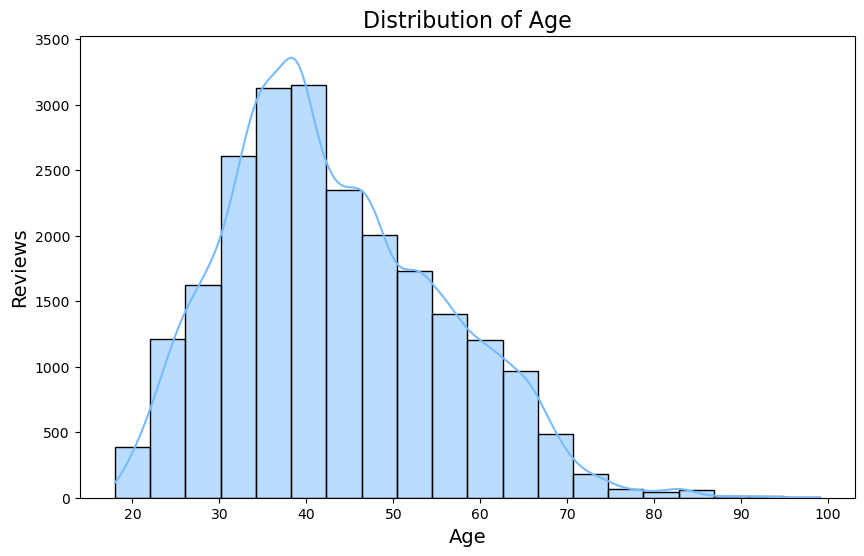

In [17]:
# Plot Age Distribution

# Histogram for Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='#77BBFF')

# Adding title and labels
plt.title('Distribution of Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Reviews', fontsize=14)

# Show the plot
plt.show()


**EDA(Text)**